# HyperCMTL

In [37]:
# set up the environment and install any missing packages:
!pip install torch torchvision numpy scipy matplotlib pandas pillow tqdm MLclf

# PyTorch for building and training neural networks
import torch
from torch import nn, utils
import torch.nn.functional as F

# Torchvision for datasets and transformations
from torchvision import models, datasets, transforms

# DataLoader for creating training and validation dataloaders
from torch.utils.data import DataLoader


# Numpy for numerical operations
import numpy as np

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Pandas for data manipulation
import pandas as pd

# PIL for image processing
from PIL import Image

# TQDM for progress bars
from tqdm import tqdm

# OS for operating system operations
import os

# Collections for ordered dictionaries
from collections import OrderedDict

# Torchmeta for meta-learning modules
from torchmeta.modules import MetaModule, MetaSequential

# Regular expressions
import re

# Custom MLclf module (imports miniimagente)
from MLclf import MLclf

# Deepcopy for copying models
from copy import deepcopy

DEPRECATION: Loading egg at /home/ndelafuente/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/ordered_set-4.1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..
DEPRECATION: Loading egg at /home/ndelafuente/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/torchmeta-1.8.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..


## DATA

### FMINIST

In [38]:
### download data:

fmnist = datasets.FashionMNIST(root='data/', download=True)
fmnist.name, fmnist.num_classes = 'Fashion-MNIST', len(fmnist.classes)
print(f'{fmnist.name}: {len(fmnist)} samples')

for i, cl in enumerate(fmnist.classes):
    print(f'{i}: {cl}')

Fashion-MNIST: 60000 samples
0: T-shirt/top
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneaker
8: Bag
9: Ankle boot


### Split-CIFAR-10

In [39]:
# Download and prepare the Split-CIFAR-10 dataset
cifar10 = datasets.CIFAR10(root='data/', download=True)
cifar10.name, cifar10.num_classes = 'CIFAR-10', len(cifar10.classes)
print(f'{cifar10.name}: {len(cifar10)} samples')

for i, cl in enumerate(cifar10.classes):
    print(f'{i}: {cl}')

Files already downloaded and verified
CIFAR-10: 50000 samples
0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck


### Mini-ImageNet

In [ ]:
#If not already downloaded, download the Mini-ImageNet dataset
if not os.path.exists('data_miniimagenet'):
    MLclf.miniimagenet_download(Download=True)


# Define any transformations you want to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

# Transform the dataset
train_dataset, validation_dataset, test_dataset = MLclf.miniimagenet_clf_dataset(
    ratio_train=0.6,  # 60% for training
    ratio_val=0.2,    # 20% for validation
    seed_value=None,  # For reproducibility, set an integer seed
    shuffle=True,     # Shuffle the dataset
    transform=transform,
    save_clf_data=True  # Save the transformed data
)


In [40]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, num_workers=0)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, num_workers=0)

In [41]:
labels_to_marks = MLclf.labels_to_marks['mini-imagenet']
marks_to_labels = MLclf.marks_to_labels['mini-imagenet']

# Print class names
for idx, class_name in marks_to_labels.items():
    print(f'{idx}: {class_name}')


n01532829: 0
n01558993: 1
n01704323: 2
n01749939: 3
n01770081: 4
n01843383: 5
n01910747: 6
n02074367: 7
n02089867: 8
n02091831: 9
n02101006: 10
n02105505: 11
n02108089: 12
n02108551: 13
n02108915: 14
n02111277: 15
n02113712: 16
n02120079: 17
n02165456: 18
n02457408: 19
n02606052: 20
n02687172: 21
n02747177: 22
n02795169: 23
n02823428: 24
n02966193: 25
n03017168: 26
n03047690: 27
n03062245: 28
n03207743: 29
n03220513: 30
n03337140: 31
n03347037: 32
n03400231: 33
n03476684: 34
n03527444: 35
n03676483: 36
n03838899: 37
n03854065: 38
n03888605: 39
n03908618: 40
n03924679: 41
n03998194: 42
n04067472: 43
n04243546: 44
n04251144: 45
n04258138: 46
n04275548: 47
n04296562: 48
n04389033: 49
n04435653: 50
n04443257: 51
n04509417: 52
n04515003: 53
n04596742: 54
n04604644: 55
n04612504: 56
n06794110: 57
n07584110: 58
n07697537: 59
n07747607: 60
n09246464: 61
n13054560: 62
n13133613: 63
n01855672: 64
n02091244: 65
n02114548: 66
n02138441: 67
n02174001: 68
n02950826: 69
n02971356: 70
n02981792: 71
n0

Visualizing and helper functions for the HyperCMTL implementation.

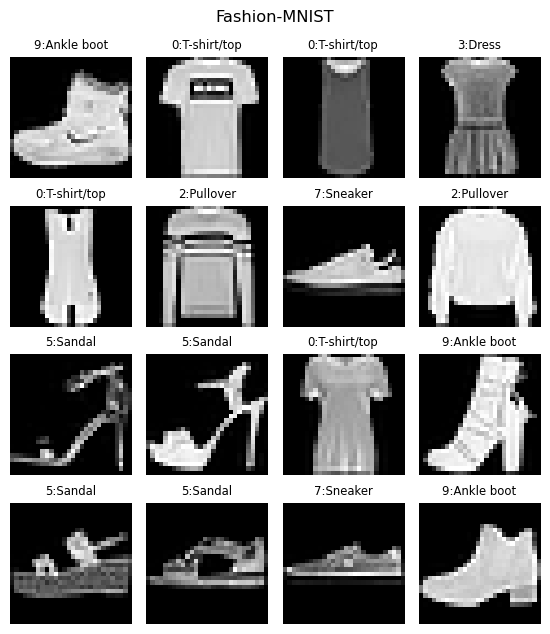

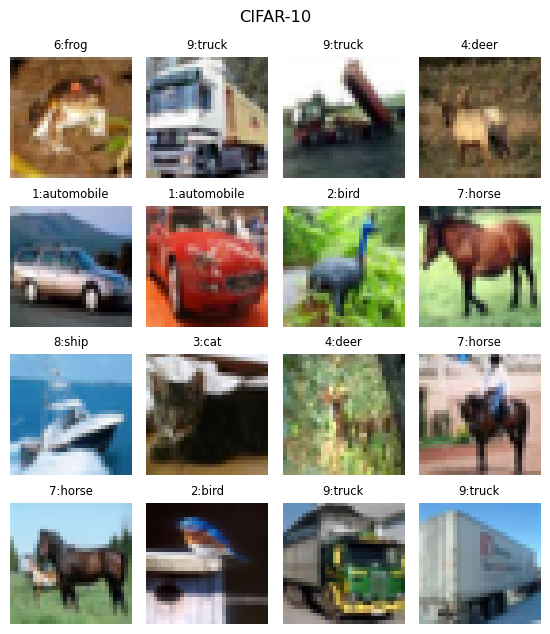

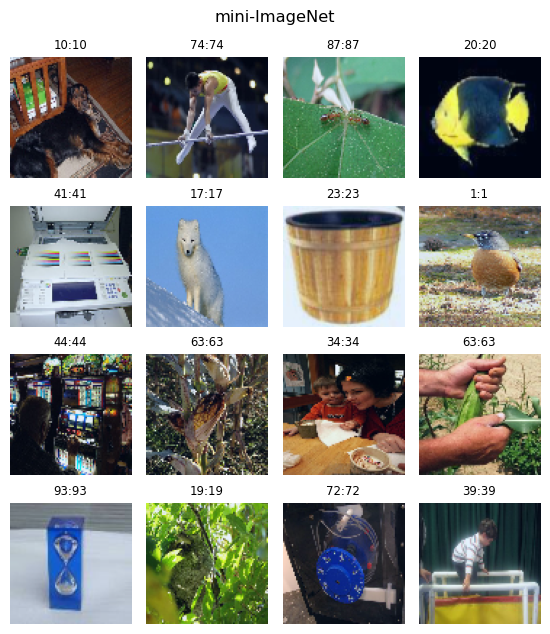

In [45]:
### helper function to inspect torch image batches:

def inspect_batch(images, labels=None, predictions=None, class_names=None, title=None,
                  center_title=True, max_to_show=16, num_cols=4, scale=1):
    """Accepts a batch of images as a torch tensor or list of tensors,
    and plots them in a grid for manual inspection.
    Optionally, you can supply ground truth labels
    and/or model predictions, to display those as well."""

    max_to_show = min(max_to_show, len(images))  # Cap at number of images
    num_rows = int(np.ceil(max_to_show / num_cols))

    # Add extra figure height if needed for captions
    extra_height = 0.2 if (labels is not None or predictions is not None) else 0

    fig_width = 2 * scale * num_cols
    fig_height = (2 + extra_height) * scale * num_rows + (0.3 if title is not None else 0)

    fig, axes = plt.subplots(num_rows, num_cols, squeeze=False, figsize=(fig_width, fig_height))
    all_axes = [ax for ax_row in axes for ax in ax_row]

    # Translate labels and predictions to class names if given
    if class_names is not None:
        if labels is not None:
            if isinstance(class_names, dict):
                # Check if class_names uses string keys (e.g., for mini-ImageNet)
                if isinstance(next(iter(class_names.keys())), str):
                    # Create labels_to_marks mapping for mini-ImageNet
                    labels_to_marks = {v: k for k, v in class_names.items()}
                    labels = [f'{l}:{class_names[labels_to_marks[l]]}' for l in labels]
                else:
                    # For datasets like CIFAR-10 or Fashion-MNIST
                    labels = [f'{l}:{class_names[l]}' for l in labels]
            else:
                # Assume class_names is a list
                labels = [f'{l}:{class_names[l]}' for l in labels]
        if predictions is not None:
            if len(predictions.shape) == 2:
                # Probability distribution or one-hot vector, so argmax it
                predictions = predictions.argmax(dim=1)
            predictions = [f'{p}:{class_names[p]}' for p in predictions]

    for b, ax in enumerate(all_axes):
        if b < max_to_show:
            # Rearrange to H*W*C
            img_p = images[b].permute([1, 2, 0])
            # Un-normalize
            img = (img_p - img_p.min()) / (img_p.max() - img_p.min())
            # To numpy
            img = img.cpu().detach().numpy()

            ax.imshow(img, cmap='gray')
            ax.axis('off')

            if labels is not None:
                ax.set_title(f'{labels[b]}', fontsize=10 * scale ** 0.5)
            if predictions is not None:
                ax.set_title(f'pred: {predictions[b]}', fontsize=10 * scale ** 0.5)
            if labels is not None and predictions is not None:
                if labels[b] == predictions[b]:
                    # Matching prediction, mark as correct
                    mark, color = '✔', 'green'
                else:
                    mark, color = '✘', 'red'

                ax.set_title(f'label:{labels[b]}\npred:{predictions[b]} {mark}', color=color, fontsize=8 * scale ** 0.5)
        else:
            ax.axis('off')
    if title is not None:
        x, align = (0.5, 'center') if center_title else (0, 'left')
        fig.suptitle(title, fontsize=14 * scale ** 0.5, x=x, horizontalalignment=align)
    fig.tight_layout()
    plt.show()



# define preprocessing transform and load a batch to inspect it:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

fmnist_batch = [fmnist[i] for i in range(16)]
fmnist_images = [preprocess(img) for (img,label) in fmnist_batch]
fmnist_labels = [label for (img,label) in fmnist_batch]

inspect_batch(fmnist_images, fmnist_labels, class_names=fmnist.classes, title='Fashion-MNIST', scale=0.7)

cifar10_batch = [cifar10[i] for i in range(16)]
cifar10_images = [preprocess(img) for (img,label) in cifar10_batch]
cifar10_labels = [label for (img,label) in cifar10_batch]

inspect_batch(cifar10_images, cifar10_labels, class_names=cifar10.classes, title='CIFAR-10', scale=0.7)

miniimagenet_batch = [test_dataset[i] for i in range(16)]
miniimagenet_images = [img for (img,label) in miniimagenet_batch]
miniimagenet_labels = [label for (img,label) in miniimagenet_batch]
# Extract scalar values from tensor labels and convert to integers
miniimagenet_labels_int = [label.item() for label in miniimagenet_labels]

# Use the integer labels in your inspect_batch function
inspect_batch(miniimagenet_images, miniimagenet_labels_int, class_names=marks_to_labels, title='mini-ImageNet', scale=0.7)


In [28]:
#Useful functions for distillation loss used in LwF

def temperature_softmax(x, T):
    """Applies temperature-scaled softmax over the channel dimension.
    
    Args:
        x (torch.Tensor): Input tensor (batch, num_classes).
        T (float): Temperature for scaling logits.

    Returns:
        torch.Tensor: Probability distribution of shape (batch, num_classes).
    """
    return torch.softmax(x / T, dim=1)

def KL_divergence(p, q, epsilon=1e-10):
    """Computes the Kullback-Leibler (KL) divergence between two distributions.
    
    Args:
        p (torch.Tensor): First probability distribution (batch, num_classes).
        q (torch.Tensor): Second probability distribution (batch, num_classes).
        epsilon (float): Small constant to avoid log(0) or division by zero.

    Returns:
        torch.Tensor: KL divergence per example in the batch (batch,).
    """
    # Add epsilon to avoid log(0) or division by zero
    p = torch.clamp(p, min=epsilon)
    q = torch.clamp(q, min=epsilon)
    
    # Compute KL divergence
    kl_div = torch.sum(p * torch.log(p / q), dim=-1)
    
    return kl_div

def distillation_output_loss(student_pred, teacher_pred, temperature):
    """Computes the distillation loss between student and teacher model predictions.
    
    Args:
        student_pred (torch.Tensor): Logits from the student model (batch, num_classes).
        teacher_pred (torch.Tensor): Logits from the teacher model (batch, num_classes).
        temperature (float): Temperature for scaling logits.

    Returns:
        torch.Tensor: Distillation loss per example in the batch (batch,).
    """
    # Apply temperature-scaled softmax to student and teacher predictions
    student_soft = temperature_softmax(student_pred, temperature)
    teacher_soft = temperature_softmax(teacher_pred, temperature)

    # Compute KL divergence as distillation loss
    kl_div = KL_divergence(student_soft, teacher_soft)
    #Only print if nan values are present
    if torch.isnan(kl_div).any():
        print(f'KL div shape: {kl_div.shape} || KL div: {kl_div} between student and teacher temperature softmax')

    # Return scaled KL divergence
    return kl_div * (temperature ** 2)

# Example usage
if __name__ == "__main__":
    student_pred = torch.tensor([[2.0, 0.5, 0.1], [1.0, 2.0, 1.5]], dtype=torch.float32)
    teacher_pred = torch.tensor([[1.5, 0.7, 0.3], [1.2, 1.8, 1.7]], dtype=torch.float32)
    temperature = 2.0

    loss = distillation_output_loss(student_pred, teacher_pred, temperature)
    print("Distillation Loss:", loss)


Distillation Loss: tensor([0.0611, 0.0192])


In [29]:
### plotting and accuracy functions:

# for this exercise, the training_plot function is able to separate the training curves
# at different timesteps, since these are different tasks with unrelated losses.
# there's also some extra functionality to plot 'soft_loss' from your LwF algorithm, if provided.
def training_plot(metrics,
      title=None, # optional figure title
      alpha=0.05, # smoothing parameter for train loss
      baselines=None, # optional list, or named dict, of baseline accuracies to compare to
      show_epochs=False,    # display boundary lines between epochs
      show_timesteps=False, # display discontinuities between CL timesteps
      ):

    for metric_name in 'train_losses', 'val_losses', 'train_accs', 'val_accs', 'epoch_steps':
        assert metric_name in metrics, f"{metric_name} missing from metrics dict"

    fig, (loss_ax, acc_ax) = plt.subplots(1,2)

    # determine where to place boundaries, by calculating steps per epoch and epochs per timestep:
    steps_per_epoch = int(np.round(len(metrics['train_losses']) / len(metrics['val_losses'])))
    epochs_per_ts = int(np.round(len(metrics['epoch_steps']) / len(metrics['CL_timesteps'])))

    # if needing to show timesteps, we plot the curves discontinuously:
    if show_timesteps:
        # break the single list of metrics into nested sub-lists:
        timestep_train_losses, timestep_val_losses = [], []
        timestep_train_accs, timestep_val_accs = [], []
        timestep_epoch_steps, timestep_soft_losses = [], []
        prev_ts = 0
        for t, ts in enumerate(metrics['CL_timesteps']):
            timestep_train_losses.append(metrics['train_losses'][prev_ts:ts])
            timestep_train_accs.append(metrics['train_accs'][prev_ts:ts])
            timestep_val_losses.append(metrics['val_losses'][t*epochs_per_ts:(t+1)*epochs_per_ts])
            timestep_val_accs.append(metrics['val_accs'][t*epochs_per_ts:(t+1)*epochs_per_ts])
            timestep_epoch_steps.append(metrics['epoch_steps'][t*epochs_per_ts:(t+1)*epochs_per_ts])
            if 'soft_losses' in metrics:
                timestep_soft_losses.append(metrics['soft_losses'][prev_ts:ts])
            else:
                timestep_soft_losses.append(None)
            prev_ts = ts
    else:
        # just treat this as one timestep, by making lists of size 1:
        timestep_train_losses = [metrics['train_losses']]
        timestep_train_accs = [metrics['train_accs']]
        timestep_val_losses = [metrics['val_losses']]
        timestep_val_accs = [metrics['val_accs']]
        timestep_epoch_steps = [metrics['epoch_steps']]
        if 'soft_losses' in metrics:
            timestep_soft_losses = metrics['soft_losses']
        else:
            timestep_soft_losses = [None]

    # zip up the individual curves at each timestep:
    timestep_metrics = zip(timestep_train_losses,
                          timestep_train_accs,
                          timestep_val_losses,
                          timestep_val_accs,
                          timestep_epoch_steps,
                          metrics['CL_timesteps'],
                          timestep_soft_losses)

    for train_losses, train_accs, val_losses, val_accs, epoch_steps, ts, soft_losses in timestep_metrics:
        ### plot loss:
        smooth_train_loss = pd.Series(train_losses).ewm(alpha=alpha).mean()
        steps = np.arange(ts-len(train_losses), ts)

        # train loss is plotted at every step:
        loss_ax.plot(steps, smooth_train_loss, 'b-', label=f'train loss')
        # but val loss is plotted at every epoch:
        loss_ax.plot(epoch_steps, val_losses, 'r-', label=f'val loss')

        ### plot soft loss if given:
        if soft_losses is not None:
            smooth_soft_loss = pd.Series(soft_losses).ewm(alpha=alpha).mean()
            loss_ax.plot(steps, smooth_soft_loss, 'g-', label=f'soft loss')

        ### plot acc:
        smooth_train_acc = pd.Series(train_accs).ewm(alpha=alpha).mean()

        acc_ax.plot(steps, smooth_train_acc, 'b-', label=f'train acc')
        acc_ax.plot(epoch_steps, val_accs, 'r-', label=f'val acc')


    loss_legend = ['train loss', 'val loss'] if 'soft_loss' not in metrics else ['train loss', 'val loss', 'soft loss']
    acc_legend = ['train acc', 'val acc']

    loss_ax.legend(loss_legend); loss_ax.set_xlabel(f'Training step'); loss_ax.set_ylabel(f'Loss (CXE)')
    acc_ax.legend(acc_legend); acc_ax.set_xlabel(f'Training step'); acc_ax.set_ylabel(f'Accuracy')

    # format as percentage on right:
    acc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1.0))
    acc_ax.yaxis.tick_right()
    acc_ax.yaxis.set_label_position('right')

    # optionally, draw lines at baseline accuracy points:
    if baselines is not None:
        if type(baselines) is list:
            for height in baselines:
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
            # rescale y-axis to accommodate baselines if needed:
            plt.ylim([0, max(list(smooth_train_acc) + metrics['val_accs'] + baselines)+0.05])
        elif type(baselines) is dict:
            for name, height in baselines.items():
                acc_ax.axhline(height, c=[0.8]*3, linestyle=':')
                # add text label as well:
                acc_ax.text(0, height+0.002, name, c=[0.6]*3, size=8)
            plt.ylim([0, max(list(smooth_train_acc) + metrics['val_accs'] + [h for h in baselines.values()])+0.05])

    # optionally, draw epoch boundaries
    if show_epochs:
        for ax in (loss_ax, acc_ax):
            for epoch in metrics['epoch_steps']:
                ax.axvline(epoch, c=[0.9]*3, linestyle=':', zorder=1)

    # and/or CL timesteps:
    if show_timesteps:
        for ax in (loss_ax, acc_ax):
            for epoch in metrics['CL_timesteps']:
                ax.axvline(epoch, c=[.7,.7,.9], linestyle='--', zorder=0)


    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def get_batch_acc(pred, y):
    """calculates accuracy over a batch as a float
    given predicted logits 'pred' and integer targets 'y'"""
    return (pred.argmax(axis=1) == y).float().mean().item()

### HyperCMTL 

#### Helper functioncs

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper Functions

def get_subdict(dictionary, key=None):
    """
    Extracts a subdictionary based on a given key prefix.
    
    Args:
        dictionary (OrderedDict): The dictionary to extract from.
        key (str, optional): The prefix to filter keys. If None or empty, returns the entire dictionary.

    Returns:
        OrderedDict: A subdictionary containing only the keys that start with the specified prefix,
        with the prefix removed from the keys.
    
    Example:
        dictionary = {'layer1.weight': ..., 'layer2.bias': ...}
        get_subdict(dictionary, 'layer1') -> {'weight': ...}
    """
    if dictionary is None:
        return None
    if (key is None) or (key == ''):
        return dictionary
    key_re = re.compile(r'^{0}\.(.+)'.format(re.escape(key)))
    return OrderedDict((key_re.sub(r'\1', k), value) for (k, value)
        in dictionary.items() if key_re.match(k) is not None)


def init_weights_normal(m):
    """
    Initializes weights of a given module with Kaiming normal initialization.
    
    Args:
        m (nn.Module): The module to initialize. Should be of type BatchLinear or nn.Linear.
    
    Note:
        The initialization uses `relu` as the nonlinearity and `fan_in` mode.
    """
    if type(m) == BatchLinear or type(m) == nn.Linear:
        if hasattr(m, 'weight'):
            nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')


def hyper_weight_init(m, in_features_main_net, siren=False):
    """
    Initializes weights for a hypernetwork-generated weight matrix.

    Args:
        m (nn.Module): The module to initialize.
        in_features_main_net (int): Number of input features for the main network.
        siren (bool, optional): Indicates whether to use initialization tailored for SIREN models.
    
    Note:
        The weights are initialized using Kaiming normal initialization and scaled down.
    """
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1e1  # Scale down weights


def hyper_bias_init(m, siren=False):
    """
    Initializes biases for a hypernetwork-generated bias vector.

    Args:
        m (nn.Module): The module to initialize.
        siren (bool, optional): Indicates whether to use initialization tailored for SIREN models.
    
    Note:
        The biases are initialized using Kaiming normal initialization and scaled down.
    """
    if hasattr(m, 'weight'):
        nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity='relu', mode='fan_in')
        m.weight.data = m.weight.data / 1.e1  # Scale down biases


#### Basic Classes

BatchLinear

In [ ]:

class BatchLinear(nn.Linear, MetaModule):
    """
    A linear meta-layer that supports batched weight matrices and biases.
    
    This layer can process weight and bias matrices in a batched fashion, which is useful
    when using it in combination with hypernetworks that output parameters for multiple tasks
    or instances. It extends PyTorch's `nn.Linear` to handle batched weights and integrates
    with MetaModules for parameter swapping.

    Inherits:
        nn.Linear: Provides standard linear layer functionality.
        MetaModule: Enables parameter substitution for meta-learning tasks.

    Attributes:
        __doc__: Inherits the docstring from `nn.Linear`.

    Methods:
        forward(input, params=None): Computes the output of the linear layer using the given input
                                     and optionally supplied weights and biases.
    """
    __doc__ = nn.Linear.__doc__  # Inherit nn.Linear's documentation for completeness

    def forward(self, input, params=None):
        """
        Forward pass for the batched linear layer.

        Args:
            input (torch.Tensor): The input tensor of shape `(batch_size, ..., input_dim)`.
            params (OrderedDict, optional): An optional dictionary containing the weights and biases.
                - `params['weight']`: Batched weight matrix of shape `(batch_size, output_dim, input_dim)`.
                - `params['bias']` (optional): Batched bias vector of shape `(batch_size, output_dim)`.

        Returns:
            torch.Tensor: The result of applying the linear transformation, of shape 
            `(batch_size, ..., output_dim)`.

        Notes:
            - If `params` is not provided, the layer uses its own parameters.
            - The weight matrix is permuted to align the last two dimensions for matrix multiplication.
        """
        # Use layer's own parameters if none are supplied
        if params is None:
            params = OrderedDict(self.named_parameters())

        # Extract weight and bias from the provided or default parameters
        weight = params['weight']
        bias = params.get('bias', None)  # Bias is optional

        # Perform batched matrix multiplication
        # Permutes weight dimensions for proper broadcasting with input
        output = input.matmul(weight.permute(*[i for i in range(len(weight.shape) - 2)], -1, -2))

        # Add bias if available
        # if bias is not None:
        #     output += bias.unsqueeze(-2)  # Add bias to output

        return output



ConvBackbone

In [75]:


class ConvBackbone(nn.Module):
    """
    A convolutional backbone for feature extraction from image data.
    Supports both grayscale (1 channel) and RGB (3 channels) input images.
    
    This module constructs a stack of convolutional layers followed by global average pooling,
    which reduces spatial dimensions and outputs a fixed-size feature vector for each input image.
    It is commonly used as a feature extractor in tasks like classification, segmentation, or
    meta-learning.

    Args:
        layers (list of int): A list specifying the number of filters in each convolutional layer.
            Default is [32, 64, 128, 256, 512].
        input_size (tuple of int): The shape of the input image in the format (channels, height, width).
            Default is (1, 32, 32), assuming grayscale images of size 32x32.
        device (torch.device): The device on which the model will run (e.g., 'cuda' or 'cpu').
            Default is the global `device` variable.

    Attributes:
        conv_stack (torch.nn.Sequential): The sequential stack of convolutional layers with ReLU activations.
        pool (torch.nn.AdaptiveAvgPool2d): Global average pooling layer to reduce spatial dimensions.
        num_features (int): The size of the feature vector output after global pooling.
        device (torch.device): The device on which the model is running.
    """

    def __init__(self,
                 layers=[32, 64, 128, 256, 512],  # List of convolutional layer sizes
                 input_size=(3, 32, 32),          # Input image size (channels, height, width)
                 device=device):
        super().__init__()

        # Extract input dimensions
        in_channels, in_h, in_w = input_size

        # Build the sequential stack of convolutional layers
        conv_layers = []  # List to store layers
        prev_layer_size = in_channels  # Initial input size (e.g., 1 for grayscale)
        for layer_size in layers:
            # Add a convolutional layer
            conv_layers.append(nn.Conv2d(prev_layer_size, layer_size, (3, 3), padding='same'))
            # Add a ReLU activation
            conv_layers.append(nn.ReLU())
            # Update the size for the next layer
            prev_layer_size = layer_size
        self.conv_stack = torch.nn.Sequential(*conv_layers)

        # Global average pooling layer to reduce spatial dimensions to (1, 1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Set the number of output features after pooling
        self.num_features = prev_layer_size  # Equal to the size of the last conv layer

        # Store the device and move the model to the specified device
        self.device = device
        self.to(device)


    def forward(self, x):
        """
        Forward pass of the convolutional backbone.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).

        Returns:
            torch.Tensor: Feature vector of shape (batch_size, num_features), where
            `num_features` is determined by the last convolutional layer.
        """
        # Pass input through the convolutional stack
        x = self.conv_stack(x)

        # Apply global average pooling to reduce spatial dimensions
        x = self.pool(x)

        # Flatten the tensor to a feature vector
        x = x.view(-1, self.num_features)

        # Return the feature vector
        return x
    
    def get_optimizer_list(self):
        """
        Returns the list of model parameters and learning rates for the optimizer.
        
        Args:
            None
        
        Returns:
            list: A list containing a single dictionary with the model parameters and learning rate.
        """
        # Return the model parameters and learning rate for the optimizer
        optimizer_list = [{'params': self.parameters(), 'lr': 1e-3}]
        return optimizer_list



TaskHead

In [76]:
class TaskHead(MetaModule):
    """
    A task-specific classification head that operates on features extracted by a backbone.

    This module consists of a projection layer followed by a classifier. The projection layer
    reduces the dimensionality of the backbone's output, while the classifier produces task-specific
    predictions. The module also supports optional dropout for regularization.

    Args:
        input_size (int): Number of input features from the backbone.
        projection_size (int): Number of neurons in the hidden (projection) layer.
        num_classes (int): Number of output neurons corresponding to the number of classes.
        dropout (float, optional): Dropout rate for regularization. Default is 0 (no dropout).
        device (torch.device, optional): The device to use for computation. Default is the global `device`.

    Attributes:
        projection (BatchLinear): Linear layer for reducing feature dimensionality.
        classifier (BatchLinear): Linear layer for producing class logits.
        dropout (nn.Module): Dropout layer (or identity if dropout=0).
        relu (nn.ReLU): ReLU activation function.
        device (torch.device): The device on which the model is running.
    """

    def __init__(self, input_size: int,  # Number of features in the backbone's output
                 projection_size: int,  # Number of neurons in the hidden layer
                 num_classes: int,      # Number of output neurons
                 dropout: float = 0.,   # Optional dropout rate to apply
                 device=device):        # Device for computation (e.g., 'cuda' or 'cpu')
        super().__init__()

        # Linear layer for projecting backbone features to a lower-dimensional space
        self.projection = BatchLinear(input_size, projection_size)

        # Linear layer for classification
        self.classifier = BatchLinear(projection_size, num_classes)

        # Dropout for regularization (use nn.Identity if no dropout is applied)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()

        # ReLU activation function
        self.relu = nn.ReLU()

        # Store the device and move the model to it
        self.device = device
        self.to(device)

    def forward(self, x, params):
        """
        Forward pass through the task-specific head.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size), typically
                              the output of a backbone.
            params (OrderedDict): Dictionary of task-specific parameters for the layers.
                - `params['projection']`: Parameters for the projection layer.
                - `params['classifier']`: Parameters for the classifier layer.

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes), where `num_classes`
                          corresponds to the number of task-specific classes.
        """
        # Apply projection layer with ReLU activation and optional dropout
        x = self.projection(self.relu(self.dropout(x)), params=get_subdict(params, 'projection'))

        # Apply classifier layer with ReLU activation and optional dropout
        x = self.classifier(self.relu(self.dropout(x)), params=get_subdict(params, 'classifier'))

        return x

    def get_optimizer_list(self):
        """
        Returns the list of model parameters and learning rates for the optimizer.

        Args:
            None

        Returns:
            list: A list containing two dictionaries with the model parameters and learning rates.
        """
        # Return the model parameters and learning rates for the optimizer
        optimizer_list = [
            {'params': self.projection.parameters(), 'lr': 1e-3},
            {'params': self.classifier.parameters(), 'lr': 1e-3}
        ]
        return optimizer_list

FCBlock

In [77]:
class FCBlock(MetaModule):
    """
    A fully connected (FC) neural network with support for weight swapping using a hypernetwork.

    This module can function as a regular fully connected network or integrate with a hypernetwork
    to allow swapping out weights dynamically during training or inference. It includes support for
    customizable nonlinearity, initialization, and flexible architectures with multiple hidden layers.

    Args:
        in_features (int): Number of input features.
        out_features (int): Number of output features.
        num_hidden_layers (int): Number of hidden layers.
        hidden_features (int): Number of neurons in each hidden layer.
        outermost_linear (bool, optional): If True, the last layer does not include a nonlinearity.
                                           Default is False.
        nonlinearity (str, optional): Nonlinearity to use between layers. Default is 'relu'.
        weight_init (callable, optional): Custom weight initialization function. Default is None.
        bias (bool, optional): Whether to include bias in the linear layers. Default is True.

    Attributes:
        net (MetaSequential): The sequential stack of layers making up the network.
        weight_init (callable): The weight initialization function applied to the layers.
        first_layer_init (callable): Special initialization for the first layer (if applicable).
    """

    def __init__(self, in_features, out_features, num_hidden_layers, hidden_features,
                 outermost_linear=False, nonlinearity='relu', weight_init=None, bias=True):
        super().__init__()

        # Initialize attributes for special initialization
        self.first_layer_init = None

        # Set default nonlinearity and initialization
        nl, nl_weight_init, first_layer_init = nn.ReLU(inplace=True), init_weights_normal, None

        # Overwrite weight initialization if a custom function is provided
        if weight_init is not None:
            self.weight_init = weight_init
        else:
            self.weight_init = nl_weight_init

        # Build the network as a stack of layers
        self.net = []

        # Add the first layer
        self.net.append(MetaSequential(
            BatchLinear(in_features, hidden_features, bias=bias), nl
        ))

        # Add hidden layers
        for i in range(num_hidden_layers):
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, hidden_features, bias=bias), nl
            ))

        # Add the final layer, optionally without nonlinearity
        if outermost_linear:
            self.net.append(MetaSequential(BatchLinear(hidden_features, out_features, bias=bias)))
        else:
            self.net.append(MetaSequential(
                BatchLinear(hidden_features, out_features, bias=bias), nl
            ))

        # Convert the list of layers into a MetaSequential module
        self.net = MetaSequential(*self.net)

        # Apply weight initialization to the network
        if self.weight_init is not None:
            self.net.apply(self.weight_init)

        # Apply special initialization to the first layer if specified
        if first_layer_init is not None:
            self.net[0].apply(first_layer_init)

    def forward(self, coords, params=None, **kwargs):
        """
        Forward pass through the fully connected network.

        Args:
            coords (torch.Tensor): Input tensor of shape `(batch_size, in_features)`.
            params (OrderedDict, optional): Dictionary of parameters for meta-learning. If None,
                                            the layer uses its own parameters.

        Returns:
            torch.Tensor: Output tensor of shape `(batch_size, out_features)`.
        """
        if params is None:
            params = OrderedDict(self.named_parameters())

        # Forward pass through the network using meta-learning parameters
        output = self.net(coords, params=get_subdict(params, 'net'))
        return output

    def forward_with_activations(self, coords, params=None, retain_grad=False):
        """
        Forward pass that returns intermediate activations for each layer.

        Args:
            coords (torch.Tensor): Input tensor of shape `(batch_size, in_features)`.
            params (OrderedDict, optional): Dictionary of parameters for meta-learning.
                                            If None, the layer uses its own parameters.
            retain_grad (bool, optional): If True, retains gradients for intermediate activations.
                                          Default is False.

        Returns:
            OrderedDict: Dictionary of intermediate activations, including the input and output of each layer.
        """
        if params is None:
            params = OrderedDict(self.named_parameters())

        activations = OrderedDict()

        # Clone input to ensure it does not modify the original tensor
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x

        # Pass through each layer and collect activations
        for i, layer in enumerate(self.net):
            subdict = get_subdict(params, f'net.{i}')
            for j, sublayer in enumerate(layer):
                if isinstance(sublayer, BatchLinear):
                    x = sublayer(x, params=get_subdict(subdict, f'{j}'))
                else:
                    x = sublayer(x)

                # Retain gradient for intermediate activations if specified
                if retain_grad:
                    x.retain_grad()
                activations[f'{sublayer.__class__.__name__}_{i}'] = x
        return activations

    def get_optimizer_list(self):
        """
        Returns a list of optimizers for the network.

        Returns:
            list of dict: List containing optimizer configurations for the parameters.
        """
        optimizer_list = [{'params': self.parameters(), 'lr': 1e-4}]
        return optimizer_list


HyperNetwork

In [78]:
class HyperNetwork(nn.Module):
    """
    A hypernetwork module for generating parameters for a target (hypo) module.

    The hypernetwork takes an input embedding and generates weights and biases
    for the target (hypo) module dynamically. Each parameter in the hypo module
    is generated by a small fully connected (FC) network.

    Args:
        hyper_in_features (int): Number of input features to the hypernetwork.
        hyper_hidden_layers (int): Number of hidden layers in each FCBlock of the hypernetwork.
        hyper_hidden_features (int): Number of hidden units in each hidden layer of the FCBlock.
        hypo_module (MetaModule): The target module whose parameters are generated by the hypernetwork.
        activation (str, optional): Activation function to use in the FCBlocks. Default is 'relu'.

    Attributes:
        names (list of str): Names of the parameters in the hypo module.
        nets (nn.ModuleList): A list of FCBlock networks, one for each parameter in the hypo module.
        param_shapes (list of torch.Size): Shapes of the parameters in the hypo module.
    """

    def __init__(self, 
                 hyper_in_features, 
                 hyper_hidden_layers, 
                 hyper_hidden_features, 
                 hypo_module, 
                 activation='relu'):
        super().__init__()

        # Extract parameter names, shapes, and initialize FCBlocks for each parameter
        hypo_parameters = hypo_module.state_dict().items()
        self.names = []  # Stores the names of the parameters in the hypo module
        self.nets = nn.ModuleList()  # Stores the FCBlock for each parameter
        self.param_shapes = []  # Stores the shape of each parameter

        for name, param in hypo_parameters:
            self.names.append(name)
            self.param_shapes.append(param.size())

            # Create an FCBlock for each parameter
            hn = FCBlock(
                in_features=hyper_in_features, 
                out_features=int(torch.prod(torch.tensor(param.size()))),
                num_hidden_layers=hyper_hidden_layers, 
                hidden_features=hyper_hidden_features,
                outermost_linear=True,
                nonlinearity=activation
            )

            # Apply custom initialization based on the parameter type
            if 'weight' in name:
                hn.net[-1].apply(lambda m: hyper_weight_init(m, param.size()[-1]))
            elif 'bias' in name or 'offsets' in name:
                hn.net[-1].apply(lambda m: hyper_bias_init(m))
            
            self.nets.append(hn)  # Add the FCBlock to the list

    def forward(self, input_hyp):
        """
        Forward pass of the hypernetwork.

        Args:
            input_hyp (torch.Tensor): Input tensor (embedding) of shape `(batch_size, hyper_in_features)`.

        Returns:
            OrderedDict: A dictionary where keys are parameter names from the hypo module and
                         values are the corresponding generated parameters, reshaped to match
                         their original shapes in the hypo module.
        """
        params = OrderedDict()

        # Generate each parameter using the corresponding FCBlock
        for name, net, param_shape in zip(self.names, self.nets, self.param_shapes):
            batch_param_shape = (-1,) + param_shape  # Add batch dimension
            params[name] = net(input_hyp).reshape(batch_param_shape)
        
        return params

    def get_optimizer_list(self):
        """
        Creates a list of optimizers for the hypernetwork's parameters.

        Returns:
            list: A list of dictionaries, each containing parameter groups for optimization.
        """
        optimizer_list = [{'params': self.parameters(), 'lr': 1e-3}]
        return optimizer_list


#### HyperCMTL class

In [87]:
class HyperCMTL(nn.Module):
    """
    Hypernetwork-based Conditional Multi-Task Learning (HyperCMTL) model.

    This model combines a convolutional backbone, a task-specific head, and a hypernetwork
    to dynamically generate parameters for task-specific learning. It is designed for
    applications requiring task conditioning, such as meta-learning or multi-task learning.

    Args:
        num_instances (int): Number of task instances to support (e.g., number of tasks).
        device (str, optional): Device for computation ('cuda' or 'cpu'). Default is 'cuda'.
        std (float, optional): Standard deviation for initializing the task embeddings. Default is 0.01.

    Attributes:
        num_instances (int): Number of task instances.
        device (torch.device): Device for computation.
        std (float): Standard deviation for embedding initialization.
        backbone (ConvBackbone): Convolutional network for feature extraction.
        task_head (TaskHead): Fully connected network for task-specific classification.
        hypernet (HyperNetwork): Hypernetwork to generate parameters for the task head.
        hyper_emb (nn.Embedding): Task-specific embeddings used as input to the hypernetwork.
    """

    def __init__(self, num_instances=1, device='cuda', std=0.01, channels=1):
        super().__init__()

        # Store configuration
        self.num_instances = num_instances
        self.device = device
        self.std = std
        self.channels = channels

        # Initialize the convolutional backbone for feature extraction
        self.backbone = ConvBackbone(
            layers=[32, 64, 128, 256, 512],  # Convolutional layer sizes
            input_size=(self.channels, 32, 32),          # Input image size (grayscale, 32x32)
            device=device
        )

        # Initialize the task-specific head
        self.task_head = TaskHead(
            input_size=self.backbone.num_features,  # Output features from the backbone
            projection_size=64,                    # Size of the projection layer
            num_classes=2,                         # Number of output classes
            dropout=0.5,                           # Dropout rate for regularization
            device=device
        )

        # Hypernetwork configuration
        hn_in = 64  # Input size for the hypernetwork (matches embedding dimension)
        self.hypernet = HyperNetwork(
            hyper_in_features=hn_in,              # Input features for hypernetwork
            hyper_hidden_layers=2,                # Number of hidden layers
            hyper_hidden_features=256,            # Hidden layer size
            hypo_module=self.task_head,           # Target module to generate parameters for
            activation='relu'                     # Activation function
        )

        # Initialize task embeddings (one per task instance)
        self.hyper_emb = nn.Embedding(self.num_instances, hn_in)
        nn.init.normal_(self.hyper_emb.weight, mean=0, std=std)  # Initialize embeddings

    def get_params(self, task_idx):
        """
        Generate task-specific parameters using the hypernetwork.

        Args:
            task_idx (int): Index of the task instance.

        Returns:
            OrderedDict: Task-specific parameters generated by the hypernetwork.
        """
        # Retrieve the embedding for the specified task
        z = self.hyper_emb(torch.LongTensor([task_idx]).to(self.device))
        # Generate parameters using the hypernetwork
        return self.hypernet(z)

    def forward(self, support_set, task_idx, **kwargs):
        """
        Forward pass through the HyperCMTL model.

        Args:
            support_set (torch.Tensor): Input tensor of shape (batch_size, channels, height, width).
            task_idx (int): Index of the task instance.

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes).
        """
        # Get task-specific parameters from the hypernetwork
        params = self.get_params(task_idx)
        # Extract features using the backbone
        backbone_out = self.backbone(support_set)
        # Apply the task-specific head with the generated parameters
        task_head_out = self.task_head(backbone_out, params=params)
        return task_head_out.squeeze(0)

    def deepcopy(self, device='cuda'):
        """
        Create a deep copy of the model, transferring it to the specified device.

        Args:
            device (str, optional): Target device for the new model. Default is 'cuda'.

        Returns:
            HyperCMTL: A deep copy of the current model.
        """
        # Create a new instance of the model
        new_model = HyperCMTL(
            num_instances=self.num_instances,
            device=self.device,
            std=self.std,
            channels=self.channels
        )
        # Copy the state dictionary
        new_model.load_state_dict(self.state_dict())
        # Transfer the model to the specified device
        return new_model.to(device)

    def get_optimizer_list(self):
        """
        Create a list of optimizers for all components of the model.

        Returns:
            list: A list of dictionaries containing parameter groups for optimization.
        """
        optimizer_list = []
        # Add optimizers for each component
        optimizer_list.append({'params': self.hyper_emb.parameters(), 'lr': 1e-3})
        optimizer_list.extend(self.hypernet.get_optimizer_list())
        optimizer_list.extend(self.backbone.get_optimizer_list())
        optimizer_list.extend(self.task_head.get_optimizer_list())

        print("optimizer_list", optimizer_list)  # Debugging output
        return optimizer_list


### Helper functions


In [88]:
# Quick function for displaying the classes of a task
def inspect_task(task_data, title=None):
    """
    Displays example images for each class in the task.

    Args:
        task_data (Dataset): The task-specific dataset containing classes and data.
        title (str, optional): Title for the visualization. Default is None.

    Returns:
        None: Displays a grid of example images for each class.
    """
    # Get the number of classes and their names as strings
    num_task_classes = len(task_data.classes)
    task_classes = tuple([str(c) for c in task_data.classes])

    # Retrieve one example image for each class
    class_image_examples = [[batch[0] for batch in task_data if batch[1] == c][0] for c in range(num_task_classes)]

    # Display the images in a grid
    inspect_batch(
        class_image_examples,
        labels=task_classes,
        scale=0.7,
        num_cols=num_task_classes,
        title=title,
        center_title=False
    )


# Basic evaluation function for a multitask model
def evaluate_model(
    multitask_model: nn.Module,  # Trained model capable of multi-task classification
    val_loader: utils.data.DataLoader,  # Task-specific validation data
    loss_fn: nn.modules.loss._Loss = nn.CrossEntropyLoss(),
):
    """
    Evaluates the model on a validation dataset.

    Args:
        multitask_model (nn.Module): The trained multitask model to evaluate.
        val_loader (DataLoader): DataLoader for the validation dataset.
        loss_fn (_Loss, optional): Loss function to calculate validation loss. Default is CrossEntropyLoss.

    Returns:
        tuple: Average validation loss and accuracy across all batches.
    """
    with torch.no_grad():
        batch_val_losses, batch_val_accs = [], []

        # Iterate over all batches in the validation DataLoader
        for batch in val_loader:
            vx, vy, task_ids = batch
            vx, vy = vx.to(device), vy.to(device)

            # Forward pass with task-specific parameters
            vpred = multitask_model(vx, task_ids[0])

            # Calculate loss and accuracy for the batch
            val_loss = loss_fn(vpred, vy)
            val_acc = get_batch_acc(vpred, vy)

            batch_val_losses.append(val_loss.item())
            batch_val_accs.append(val_acc)

    # Return average loss and accuracy across all batches
    return np.mean(batch_val_losses), np.mean(batch_val_accs)


# Evaluate the model on the test sets of all tasks
def test_evaluate(
    multitask_model: nn.Module,  # Trained model capable of multi-task classification
    selected_test_sets: list[utils.data.Dataset],  # Task-specific test datasets
    prev_accs: list[list[float]] = None,  # Previous taskwise accuracies for comparison
    show_taskwise_accuracy=True,  # Whether to plot taskwise accuracy as a bar chart
    baseline_taskwise_accs: list[float] = None,  # Optional baseline performance for comparison
    model_name: str = '',  # Optional model name for display
    verbose=False,  # Whether to print detailed output
):
    """
    Evaluates the model on all selected test sets and optionally displays results.

    Args:
        multitask_model (nn.Module): The trained multitask model to evaluate.
        selected_test_sets (list[Dataset]): List of test datasets for each task.
        prev_accs (list[list[float]], optional): Previous accuracies for tracking forgetting.
        show_taskwise_accuracy (bool, optional): If True, plots a bar chart of taskwise accuracies.
        baseline_taskwise_accs (list[float], optional): Baseline accuracies for comparison.
        model_name (str, optional): Name of the model to show in plots. Default is ''.
        verbose (bool, optional): If True, prints detailed evaluation results. Default is False.

    Returns:
        list[float]: Taskwise accuracies for the selected test sets.
    """
    if verbose:
        print(f'{model_name.capitalize()} evaluation on test set of all tasks:')

    task_test_losses = []
    task_test_accs = []

    # Iterate over each task's test dataset
    for t, test_data in enumerate(selected_test_sets):
        # Create a DataLoader for the current task's test dataset
        test_loader = utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

        # Evaluate the model on the current task
        task_test_loss, task_test_acc = evaluate_model(multitask_model, test_loader)

        if verbose:
            print(f'{test_data.classes}: {task_test_acc:.2%}')
            if baseline_taskwise_accs is not None:
                print(f'(Baseline: {baseline_taskwise_accs[t]:.2%})')

        task_test_losses.append(task_test_loss)
        task_test_accs.append(task_test_acc)

    # Calculate average test loss and accuracy across all tasks
    avg_task_test_loss = np.mean(task_test_losses)
    avg_task_test_acc = np.mean(task_test_accs)

    if verbose:
        print(f'\n+++ Average Task Test Accuracy: {avg_task_test_acc:.2%} +++')

    # Plot taskwise accuracy if enabled
    if show_taskwise_accuracy:
        bar_heights = task_test_accs + [0] * (len(task_test_sets) - len(selected_test_sets))

        # Display bar plot with accuracy for each task
        plt.bar(x=range(len(task_test_sets)), height=bar_heights, zorder=1)
        plt.xticks(range(len(task_test_sets)), [','.join(task.classes) for task in task_test_sets], rotation='vertical')
        plt.axhline(avg_task_test_acc, c=[0.4] * 3, linestyle=':')
        plt.text(0, avg_task_test_acc + 0.002, f'{model_name} (average)', c=[0.4] * 3, size=8)

        # Show previous step's accuracies (highlight forgetting in red)
        if prev_accs is not None:
            for p, prev_acc_list in enumerate(prev_accs):
                plt.bar(
                    x=range(len(prev_acc_list)),
                    height=prev_acc_list,
                    fc='tab:red',
                    zorder=0,
                    alpha=0.5 * ((p + 1) / len(prev_accs)),
                )

        # Plot baseline accuracies if available
        if baseline_taskwise_accs is not None:
            for t, acc in enumerate(baseline_taskwise_accs):
                plt.plot([t - 0.5, t + 0.5], [acc, acc], c='black', linestyle='--')

            # Show average baseline accuracy
            baseline_avg = np.mean(baseline_taskwise_accs)
            plt.axhline(baseline_avg, c=[0.6] * 3, linestyle=':')
            plt.text(0, baseline_avg + 0.002, 'Baseline average', c=[0.6] * 3, size=8)

        plt.show()

    return task_test_accs


### Initial Experiment with FMNIST (4 tasks)

Time 0: Task ID 0, 10200 train, 1200 validation, 600 test


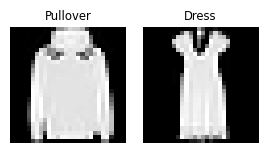

Time 1: Task ID 1, 10200 train, 1200 validation, 600 test


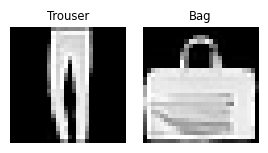

Time 2: Task ID 2, 10200 train, 1200 validation, 600 test


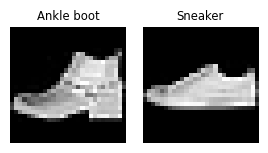

Time 3: Task ID 3, 10200 train, 1200 validation, 600 test


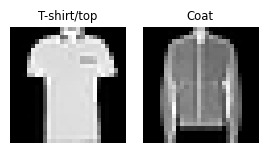

Final test set size (containing all tasks): 2400
Joint training set size (containing all tasks): 40800


In [69]:
# divide the classes along different time steps:

timestep_task_classes = {
    0: ['Pullover', 'Dress'], # task 0
    1: ['Trouser', 'Bag'],   # task 1
    2: ['Ankle boot', 'Sneaker'], # task 2
    3: ['T-shirt/top', 'Coat'], # task 3
    }

# PIL image preprocessing transform:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# data/loader constants:
VAL_FRAC = 0.1
TEST_FRAC = 0.05
BATCH_SIZE = 256

# build task datasets for each timestep:
timestep_tasks = {}
timestep_loaders = {}

task_test_sets = []

for t, task_classes in timestep_task_classes.items():
    task_class_labels = [fmnist.class_to_idx[cl] for cl in task_classes] # original labels in fmnist source data
    task_datapoint_idxs = [i for i,label in enumerate(fmnist.targets) if label in task_class_labels]

    task_datapoints = [fmnist[idx] for idx in task_datapoint_idxs]

    class_to_idx = {task_classes[t]: t for t in range(len(task_classes))}

    task_images = [preprocess(img) for (img, label) in task_datapoints]
    task_labels = [class_to_idx[fmnist.classes[label]] for (img, label) in task_datapoints] # new labels

    # in addition to the images and labels, each task dataset now comes with a 'task id'
    # that tells the model which learned task to perform:
    task_ids = [t] * len(task_datapoints)

    task_image_tensor = torch.Tensor(torch.stack(task_images))
    task_label_tensor = torch.Tensor(task_labels).long()
    task_id_tensor = torch.Tensor(task_ids).long()

    task_data = utils.data.TensorDataset(task_image_tensor, task_label_tensor, task_id_tensor)

    # train/validation split:
    train_frac  = 1.0 - VAL_FRAC - TEST_FRAC
    task_train, task_val, task_test = utils.data.random_split(task_data, [train_frac, VAL_FRAC, TEST_FRAC])

    # set dataset attributes to reflect what they contain:
    for data in (task_train, task_val, task_test):
        data.classes      = task_classes
        data.num_classes  = len(task_classes)
        data.class_to_idx = class_to_idx
        data.task_id      = t

    # inspect samples of both classes:
    print(f'Time {t}: Task ID {t}, {len(task_train)} train, {len(task_val)} validation, {len(task_test)} test')
    inspect_task(task_train)

    # add train/val data to timestep dict, and test data to the list of test sets
    timestep_tasks[t] = task_train, task_val
    task_test_sets.append(task_test)


# for final evaluation of the model, we evaluate on all task test sets jointly:
final_test_data = utils.data.ConcatDataset(task_test_sets)
final_test_loader = utils.data.DataLoader(final_test_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)
print(f'Final test set size (containing all tasks): {len(final_test_data)}')


# and we will also run a joint training loop on the whole training dataset at once to see upper bound performance
joint_train_data = utils.data.ConcatDataset([train for train,val in timestep_tasks.values()])
joint_train_loader = utils.data.DataLoader(joint_train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

print(f'Joint training set size (containing all tasks): {len(joint_train_data)}')


optimizer_list [{'params': <generator object Module.parameters at 0x7137aa1be0a0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137aa1bdfc0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137aa1bedc0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137aa1be340>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137aa1be260>, 'lr': 0.001}]
Training on task id: 0  (classification between: ['Pullover', 'Dress'])


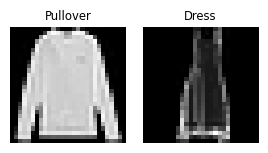

E0 batch loss:0.69, batch acc:52.3%:   5%|█▎                         | 2/40 [00:00<00:05,  6.56it/s]

E0 batch loss:0.30, batch acc:87.5%: 100%|██████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


E0 loss:0.56|v:0.51| acc t:70.0%|v:72.2%


E1 batch loss:0.29, batch acc:87.5%: 100%|██████████████████████████| 40/40 [00:05<00:00,  6.79it/s]


E1 loss:0.38|v:0.19| acc t:84.8%|v:93.0%


E2 batch loss:0.17, batch acc:93.5%: 100%|██████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


E2 loss:0.24|v:0.19| acc t:91.8%|v:92.4%


E3 batch loss:0.22, batch acc:92.6%: 100%|██████████████████████████| 40/40 [00:05<00:00,  6.78it/s]


E3 loss:0.18|v:0.17| acc t:94.5%|v:95.2%


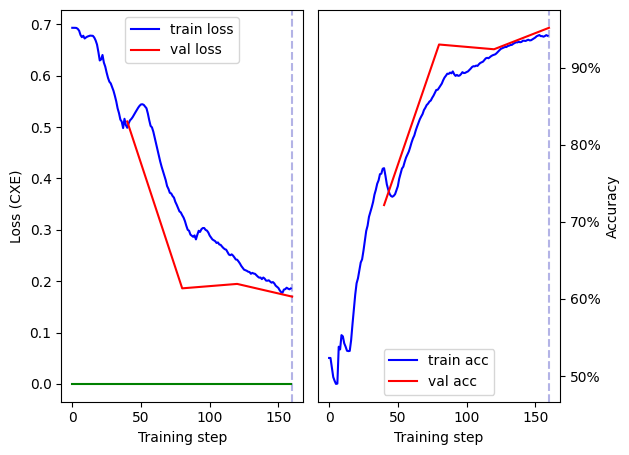

Best validation accuracy: 95.18%

Lwf at t=0 evaluation on test set of all tasks:
['Pullover', 'Dress']: 94.97%

+++ Average Task Test Accuracy: 94.97% +++


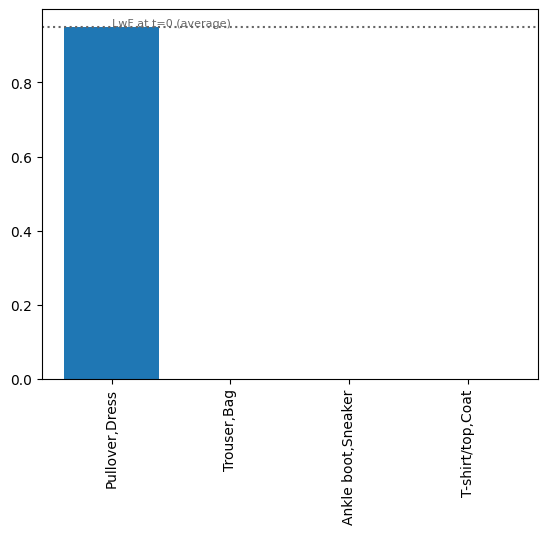

Training on task id: 1  (classification between: ['Trouser', 'Bag'])


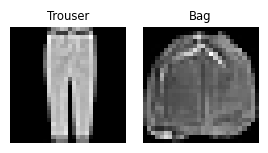

E0 batch loss:0.32, batch acc:89.8%: 100%|██████████████████████████| 40/40 [00:13<00:00,  2.98it/s]


E0 loss:0.55|v:0.29| acc t:63.9%|v:89.4%


E1 batch loss:0.26, batch acc:92.6%: 100%|██████████████████████████| 40/40 [00:13<00:00,  2.98it/s]


E1 loss:0.28|v:0.25| acc t:91.4%|v:92.4%


E2 batch loss:0.26, batch acc:92.1%: 100%|██████████████████████████| 40/40 [00:13<00:00,  2.98it/s]


E2 loss:0.23|v:0.19| acc t:94.0%|v:95.1%


E3 batch loss:0.17, batch acc:96.3%: 100%|██████████████████████████| 40/40 [00:13<00:00,  2.98it/s]


E3 loss:0.19|v:0.13| acc t:94.8%|v:96.2%


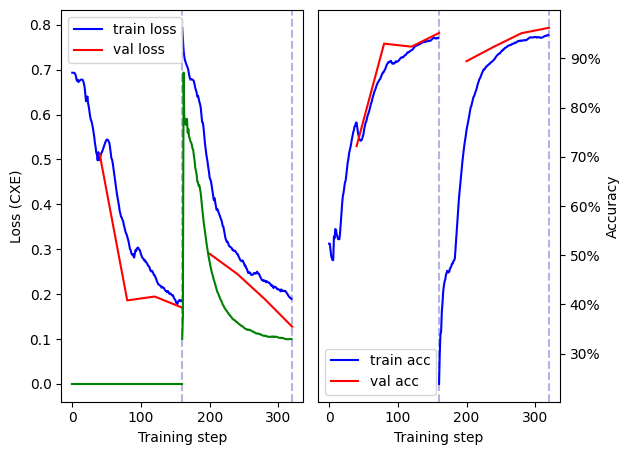

Best validation accuracy: 96.23%

Lwf at t=1 evaluation on test set of all tasks:
['Pullover', 'Dress']: 93.03%
['Trouser', 'Bag']: 94.86%

+++ Average Task Test Accuracy: 93.95% +++


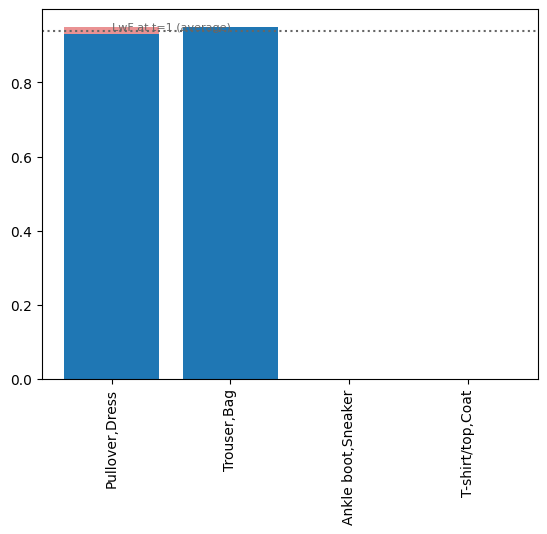

Training on task id: 2  (classification between: ['Ankle boot', 'Sneaker'])


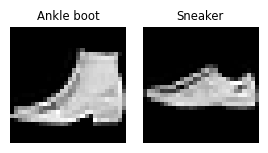

E0 batch loss:0.61, batch acc:69.9%: 100%|██████████████████████████| 40/40 [00:20<00:00,  1.91it/s]


E0 loss:0.63|v:0.60| acc t:60.5%|v:71.1%


E1 batch loss:0.60, batch acc:70.8%: 100%|██████████████████████████| 40/40 [00:20<00:00,  1.91it/s]


E1 loss:0.57|v:0.47| acc t:71.6%|v:80.4%


E2 batch loss:0.40, batch acc:82.9%: 100%|██████████████████████████| 40/40 [00:20<00:00,  1.91it/s]


E2 loss:0.45|v:0.39| acc t:80.9%|v:85.7%


E3 batch loss:0.30, batch acc:89.4%: 100%|██████████████████████████| 40/40 [00:20<00:00,  1.91it/s]


E3 loss:0.35|v:0.31| acc t:86.8%|v:88.3%


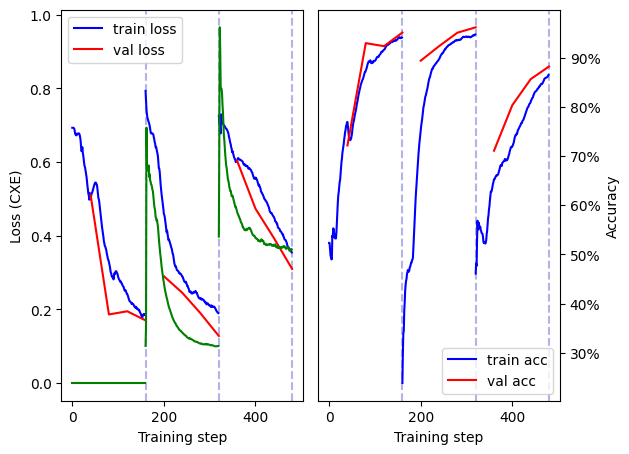

Best validation accuracy: 88.25%

Lwf at t=2 evaluation on test set of all tasks:
['Pullover', 'Dress']: 85.48%
['Trouser', 'Bag']: 91.25%
['Ankle boot', 'Sneaker']: 90.86%

+++ Average Task Test Accuracy: 89.20% +++


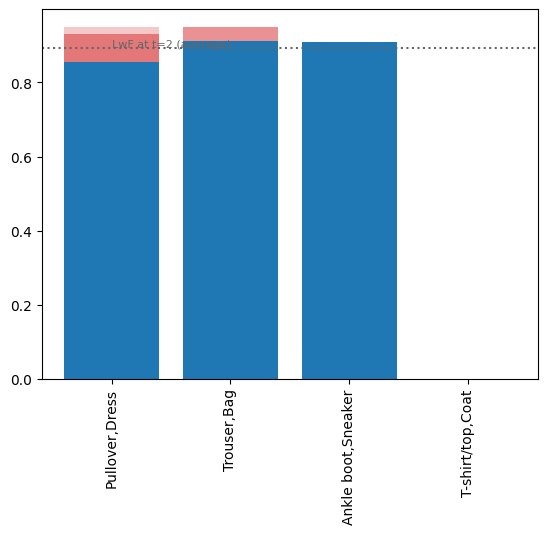

Training on task id: 3  (classification between: ['T-shirt/top', 'Coat'])


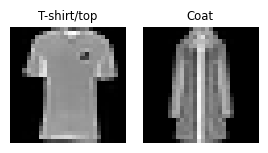

E0 batch loss:0.60, batch acc:73.6%: 100%|██████████████████████████| 40/40 [00:28<00:00,  1.40it/s]


E0 loss:0.57|v:0.52| acc t:73.2%|v:78.2%


E1 batch loss:0.51, batch acc:75.5%: 100%|██████████████████████████| 40/40 [00:28<00:00,  1.40it/s]


E1 loss:0.52|v:0.50| acc t:78.7%|v:78.5%


E2 batch loss:0.48, batch acc:80.1%: 100%|██████████████████████████| 40/40 [00:28<00:00,  1.40it/s]


E2 loss:0.50|v:0.49| acc t:79.2%|v:78.3%


E3 batch loss:0.51, batch acc:80.1%: 100%|██████████████████████████| 40/40 [00:28<00:00,  1.40it/s]


E3 loss:0.51|v:0.49| acc t:79.2%|v:80.9%


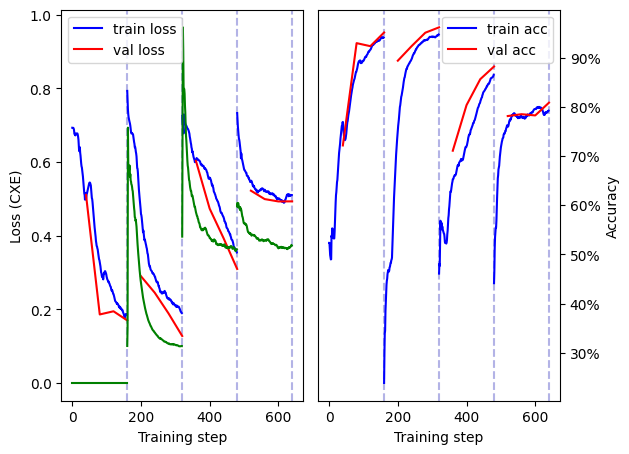

Best validation accuracy: 80.89%

Lwf at t=3 evaluation on test set of all tasks:
['Pullover', 'Dress']: 89.94%
['Trouser', 'Bag']: 77.73%
['Ankle boot', 'Sneaker']: 88.52%
['T-shirt/top', 'Coat']: 82.19%

+++ Average Task Test Accuracy: 84.59% +++


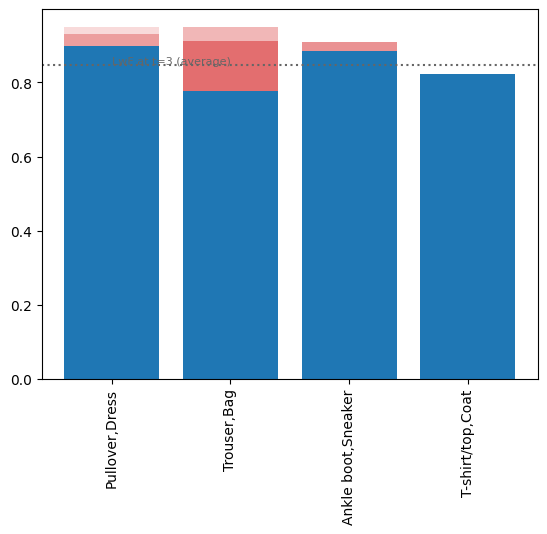

Final average test accuracy: 84.59%


In [ ]:
### Learning without Forgetting + Hypernetworks


torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HyperCMTL(num_instances=4, device=device, std=0.01, channels=1).to(device)

previous_model = None

### training hyperparameters:
EPOCHS_PER_TIMESTEP = 4
lr     = 1e-4  # initial learning rate
l2_reg = 1e-6  # L2 weight decay term (0 means no regularisation)
temperature = 2.0  # temperature scaling factor for distillation loss
stability = 5 #`stability` term to balance this soft loss with the usual hard label loss for the current classification task.

# Initialize optimizer and loss function:
opt = torch.optim.AdamW(model.get_optimizer_list())
loss_fn = nn.CrossEntropyLoss()

### metrics and plotting:
plot_training = True   # show training plots after each timestep
show_progress = True   # show progress bars and end-of-epoch metrics
verbose       = True   # output extra info to console

# track metrics for plotting training curves:
metrics = { 'train_losses': [],
              'train_accs': [],
              'val_losses': [],
                'val_accs': [],
             'epoch_steps': [], # used for plotting val loss at the correct x-position
            'CL_timesteps': [], # used to draw where each new timestep begins
            'best_val_acc': 0.0,
           'steps_trained': 0,
             'soft_losses': [], # distillation loss
          }

prev_test_accs = []

# outer loop over each task, in sequence
for t, (task_train, task_val) in timestep_tasks.items():
    print(f"Training on task id: {t}  (classification between: {task_train.classes})")
    if verbose:
        inspect_task(task_train)

    # build train and validation loaders for the current task:
    train_loader, val_loader = [utils.data.DataLoader(data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)
                                    for data in (task_train, task_val)]

    # inner loop over the current task:
    for e in range(EPOCHS_PER_TIMESTEP):
        epoch_train_losses, epoch_train_accs = [], []
        epoch_soft_losses = []

        progress_bar = tqdm(train_loader, ncols=100) if show_progress else train_loader
        num_batches = len(train_loader)
        for batch_idx, batch in enumerate(progress_bar):
            #Get data from batch
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
            task_id = task_ids[0]

            # zero the gradients
            opt.zero_grad()

            # get the predictions from the model
            pred = model(x, task_id).squeeze(0)
            # print('pred shape', pred.shape, 'y shape', y.shape)
            hard_loss = loss_fn(pred, y)

            #if previous model exists, calculate distillation loss
            soft_loss = 0.0
            if previous_model is not None:
                for old_task_id in range(t):
                    with torch.no_grad():
                
                        old_pred = previous_model(x, old_task_id)
                    new_prev_pred = model(x, old_task_id)
                    soft_loss += distillation_output_loss(new_prev_pred, old_pred, temperature).mean()

            #add the distillation loss to the total loss
            total_loss = hard_loss + stability * soft_loss
           
            #backpropagate the loss
            total_loss.backward()
            opt.step()

            # track loss and accuracy:
            epoch_train_losses.append(hard_loss.item())
            epoch_train_accs.append(get_batch_acc(pred, y))
            epoch_soft_losses.append(soft_loss.item() if isinstance(soft_loss, torch.Tensor) else soft_loss)
            metrics['steps_trained'] += 1

            if show_progress:
                # show loss/acc of this batch in progress bar:
                progress_bar.set_description((f'E{e} batch loss:{hard_loss:.2f}, batch acc:{epoch_train_accs[-1]:>5.1%}'))

        # evaluate after each epoch on the current task's validation set:
        avg_val_loss, avg_val_acc = evaluate_model(model, val_loader, loss_fn)

        ### update metrics:
        metrics['epoch_steps'].append(metrics['steps_trained'])
        metrics['train_losses'].extend(epoch_train_losses)
        metrics['train_accs'].extend(epoch_train_accs)
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_accs'].append(avg_val_acc)
        metrics['soft_losses'].extend(epoch_soft_losses)

        if show_progress:
            # print end-of-epoch stats:
            print((f'E{e} loss:{np.mean(epoch_train_losses):.2f}|v:{avg_val_loss:.2f}' +
                                  f'| acc t:{np.mean(epoch_train_accs):>5.1%}|v:{avg_val_acc:>5.1%}'))

        if avg_val_acc > metrics['best_val_acc']:
            metrics['best_val_acc'] = avg_val_acc

    # this one is important for nice plots:
    metrics['CL_timesteps'].append(metrics['steps_trained'])

    # plot training curves only if validation losses exist
    if plot_training and len(metrics['val_losses']) > 0:
        training_plot(metrics, show_timesteps=True)

    if verbose:
        print(f'Best validation accuracy: {metrics["best_val_acc"]:.2%}\n')
    metrics['best_val_acc'] = 0.0

    # evaluate on all tasks:
    test_accs = test_evaluate(model, task_test_sets[:t+1],
                              model_name=f'HyperLwF at t={t}',
                              prev_accs = prev_test_accs,
                            #   baseline_taskwise_accs = baseline_taskwise_test_accs,
                              verbose=True)
    prev_test_accs.append(test_accs)

    #store the current model as the previous model
    previous_model = model.deepcopy(device = device)

final_avg_test_acc = np.mean(test_accs)
print(f'Final average test accuracy: {final_avg_test_acc:.2%}')
# print(f'  (baseline): {np.mean(baseline_taskwise_test_accs):.2%}')

### Split CIFAR-10 (5 tasks)

Time 0: Task ID 0, 8500 train, 1000 validation, 500 test


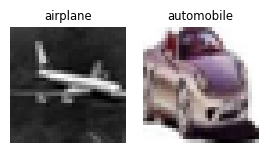

Time 1: Task ID 1, 8500 train, 1000 validation, 500 test


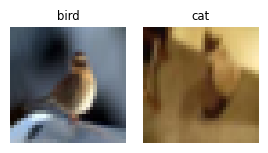

Time 2: Task ID 2, 8500 train, 1000 validation, 500 test


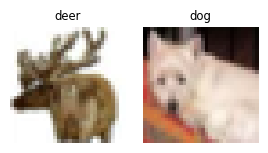

Time 3: Task ID 3, 8500 train, 1000 validation, 500 test


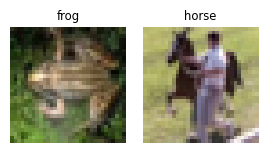

Time 4: Task ID 4, 8500 train, 1000 validation, 500 test


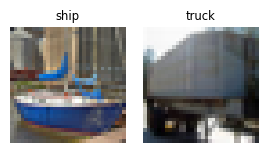

Final test set size (containing all tasks): 2500
Joint training set size (containing all tasks): 42500


In [89]:
# divide the classes along different time steps:

timestep_task_classes = {
    0: ['airplane', 'automobile'], # task 0
    1: ['bird', 'cat'],   # task 1
    2: ['deer', 'dog'], # task 2
    3: ['frog', 'horse'], # task 3
    4: ['ship', 'truck'], # task 4
    }


# PIL image preprocessing transform:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for 3 channels
])



# data/loader constants:
VAL_FRAC = 0.1
TEST_FRAC = 0.05
BATCH_SIZE = 256

# build task datasets for each timestep:
timestep_tasks = {}
timestep_loaders = {}

task_test_sets = []

for t, task_classes in timestep_task_classes.items():
    task_class_labels = [cifar10.class_to_idx[cl] for cl in task_classes] # original labels in cifar10 source data
    task_datapoint_idxs = [i for i,label in enumerate(cifar10.targets) if label in task_class_labels]

    task_datapoints = [cifar10[idx] for idx in task_datapoint_idxs]

    class_to_idx = {task_classes[t]: t for t in range(len(task_classes))}

    task_images = [preprocess(img) for (img, label) in task_datapoints]
    task_labels = [class_to_idx[cifar10.classes[label]] for (img, label) in task_datapoints] # new labels

    # in addition to the images and labels, each task dataset now comes with a 'task id'
    # that tells the model which learned task to perform:
    task_ids = [t] * len(task_datapoints)

    task_image_tensor = torch.Tensor(torch.stack(task_images))
    task_label_tensor = torch.Tensor(task_labels).long()
    task_id_tensor = torch.Tensor(task_ids).long()

    task_data = utils.data.TensorDataset(task_image_tensor, task_label_tensor, task_id_tensor)

    # train/validation split:
    train_frac  = 1.0 - VAL_FRAC - TEST_FRAC
    task_train, task_val, task_test = utils.data.random_split(task_data, [train_frac, VAL_FRAC, TEST_FRAC])

    # set dataset attributes to reflect what they contain:
    for data in (task_train, task_val, task_test):
        data.classes      = task_classes
        data.num_classes  = len(task_classes)
        data.class_to_idx = class_to_idx
        data.task_id      = t

    # inspect samples of both classes:
    print(f'Time {t}: Task ID {t}, {len(task_train)} train, {len(task_val)} validation, {len(task_test)} test')
    inspect_task(task_train)

    # add train/val data to timestep dict, and test data to the list of test sets
    timestep_tasks[t] = task_train, task_val
    task_test_sets.append(task_test)


# for final evaluation of the model, we evaluate on all task test sets jointly:
final_test_data = utils.data.ConcatDataset(task_test_sets)
final_test_loader = utils.data.DataLoader(final_test_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)
print(f'Final test set size (containing all tasks): {len(final_test_data)}')


# and we will also run a joint training loop on the whole training dataset at once to see upper bound performance
joint_train_data = utils.data.ConcatDataset([train for train,val in timestep_tasks.values()])
joint_train_loader = utils.data.DataLoader(joint_train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

print(f'Joint training set size (containing all tasks): {len(joint_train_data)}')


optimizer_list [{'params': <generator object Module.parameters at 0x7137bf6f7a00>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137bf6f57e0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137bf6f59a0>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137bf6f5a80>, 'lr': 0.001}, {'params': <generator object Module.parameters at 0x7137bf6f6260>, 'lr': 0.001}]
Training on task id: 0  (classification between: ['airplane', 'automobile'])


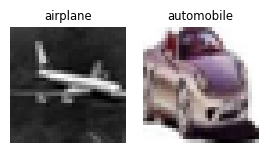

E0 batch loss:0.69, batch acc:74.2%:  15%|███▉                       | 5/34 [00:01<00:05,  4.94it/s]

E0 batch loss:0.60, batch acc:59.6%: 100%|██████████████████████████| 34/34 [00:06<00:00,  5.15it/s]


E0 loss:0.66|v:0.62| acc t:60.5%|v:70.8%


E1 batch loss:0.58, batch acc:65.4%: 100%|██████████████████████████| 34/34 [00:06<00:00,  5.20it/s]


E1 loss:0.56|v:0.53| acc t:73.5%|v:71.8%


E2 batch loss:0.45, batch acc:86.5%: 100%|██████████████████████████| 34/34 [00:06<00:00,  5.20it/s]


E2 loss:0.47|v:0.44| acc t:79.3%|v:82.7%


E3 batch loss:0.48, batch acc:80.8%: 100%|██████████████████████████| 34/34 [00:06<00:00,  5.19it/s]


E3 loss:0.43|v:0.44| acc t:82.5%|v:80.6%


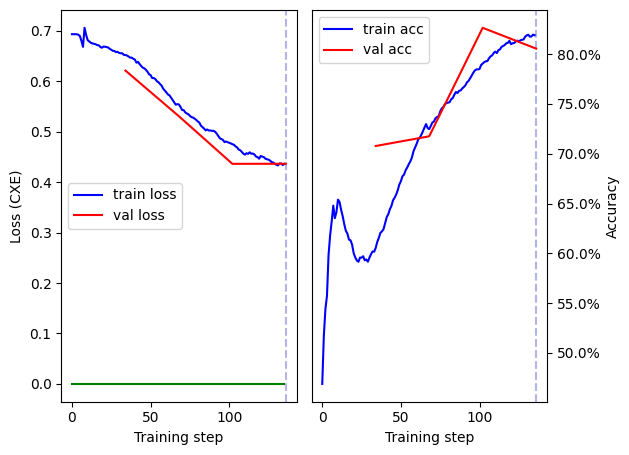

Best validation accuracy: 82.65%

Hyperlwf at t=0 evaluation on test set of all tasks:
['airplane', 'automobile']: 79.37%

+++ Average Task Test Accuracy: 79.37% +++


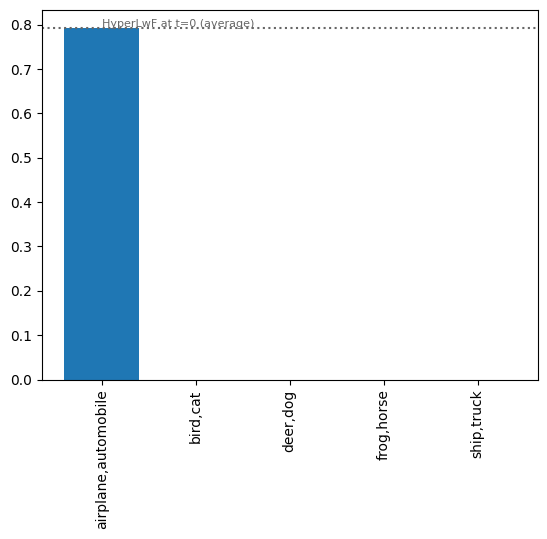

Training on task id: 1  (classification between: ['bird', 'cat'])


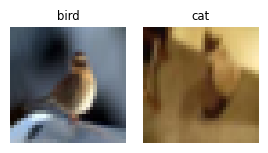

E0 batch loss:0.65, batch acc:55.8%: 100%|██████████████████████████| 34/34 [00:15<00:00,  2.26it/s]


E0 loss:0.65|v:0.65| acc t:62.1%|v:62.8%


E1 batch loss:0.61, batch acc:67.3%: 100%|██████████████████████████| 34/34 [00:15<00:00,  2.26it/s]


E1 loss:0.63|v:0.64| acc t:65.0%|v:63.9%


E2 batch loss:0.68, batch acc:55.8%: 100%|██████████████████████████| 34/34 [00:15<00:00,  2.26it/s]


E2 loss:0.63|v:0.63| acc t:65.2%|v:65.1%


E3 batch loss:0.67, batch acc:55.8%: 100%|██████████████████████████| 34/34 [00:15<00:00,  2.26it/s]


E3 loss:0.62|v:0.61| acc t:66.1%|v:66.5%


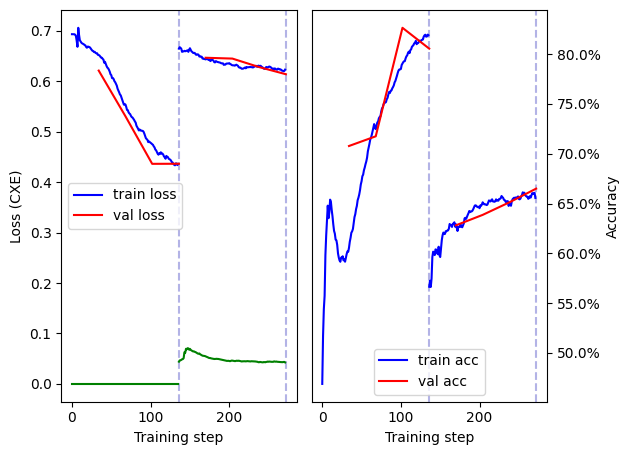

Best validation accuracy: 66.49%

Hyperlwf at t=1 evaluation on test set of all tasks:
['airplane', 'automobile']: 74.34%
['bird', 'cat']: 68.56%

+++ Average Task Test Accuracy: 71.45% +++


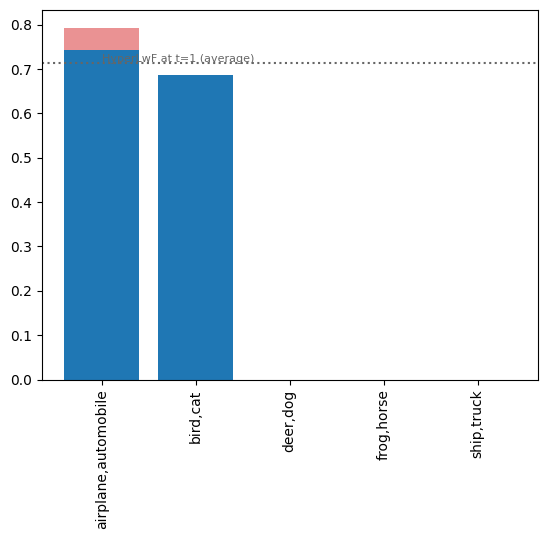

Training on task id: 2  (classification between: ['deer', 'dog'])


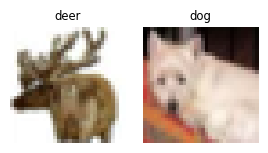

E0 batch loss:0.57, batch acc:76.9%: 100%|██████████████████████████| 34/34 [00:23<00:00,  1.44it/s]


E0 loss:0.62|v:0.62| acc t:66.1%|v:64.7%


E1 batch loss:0.56, batch acc:71.2%: 100%|██████████████████████████| 34/34 [00:23<00:00,  1.45it/s]


E1 loss:0.60|v:0.62| acc t:67.6%|v:64.8%


E2 batch loss:0.72, batch acc:57.7%: 100%|██████████████████████████| 34/34 [00:23<00:00,  1.45it/s]


E2 loss:0.60|v:0.61| acc t:67.5%|v:66.0%


E3 batch loss:0.56, batch acc:73.1%: 100%|██████████████████████████| 34/34 [00:23<00:00,  1.44it/s]


E3 loss:0.58|v:0.60| acc t:69.1%|v:67.6%


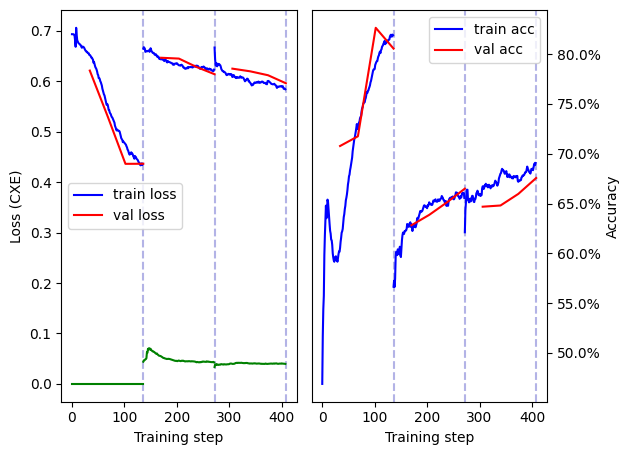

Best validation accuracy: 67.56%

Hyperlwf at t=2 evaluation on test set of all tasks:
['airplane', 'automobile']: 70.18%
['bird', 'cat']: 70.85%
['deer', 'dog']: 74.09%

+++ Average Task Test Accuracy: 71.71% +++


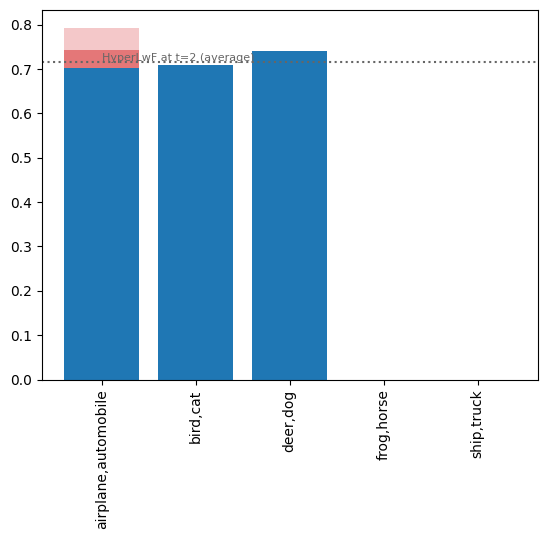

Training on task id: 3  (classification between: ['frog', 'horse'])


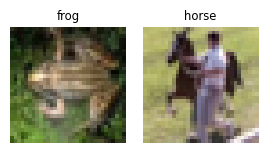

E0 batch loss:0.69, batch acc:53.8%: 100%|██████████████████████████| 34/34 [00:32<00:00,  1.06it/s]


E0 loss:0.65|v:0.64| acc t:62.3%|v:61.5%


E1 batch loss:0.64, batch acc:63.5%: 100%|██████████████████████████| 34/34 [00:32<00:00,  1.06it/s]


E1 loss:0.63|v:0.63| acc t:64.0%|v:63.8%


E2 batch loss:0.62, batch acc:61.5%: 100%|██████████████████████████| 34/34 [00:32<00:00,  1.06it/s]


E2 loss:0.63|v:0.63| acc t:63.8%|v:63.5%


E3 batch loss:0.58, batch acc:73.1%: 100%|██████████████████████████| 34/34 [00:32<00:00,  1.06it/s]


E3 loss:0.61|v:0.61| acc t:66.0%|v:66.2%


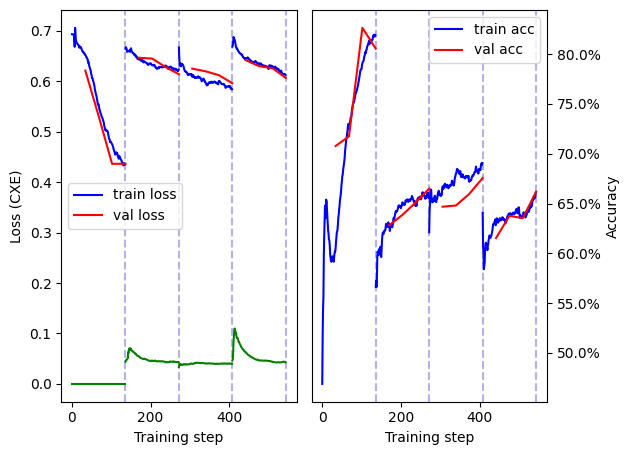

Best validation accuracy: 66.19%

Hyperlwf at t=3 evaluation on test set of all tasks:
['airplane', 'automobile']: 69.37%
['bird', 'cat']: 70.40%
['deer', 'dog']: 74.40%
['frog', 'horse']: 69.61%

+++ Average Task Test Accuracy: 70.95% +++


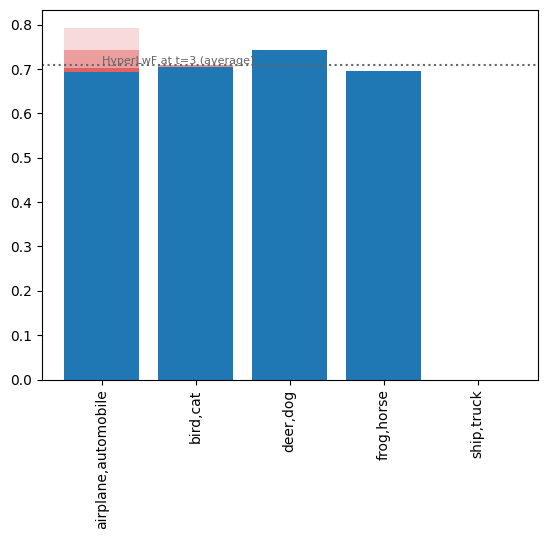

Training on task id: 4  (classification between: ['ship', 'truck'])


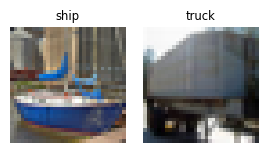

  0%|                                                                        | 0/34 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 15.48 GiB of which 468.69 MiB is free. Process 29330 has 8.16 GiB memory in use. Including non-PyTorch memory, this process has 6.37 GiB memory in use. Of the allocated memory 5.03 GiB is allocated by PyTorch, and 1.16 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [91]:
### Learning without Forgetting + Hypernetworks


torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HyperCMTL(num_instances=5, device=device, std=0.01, channels=3).to(device)

previous_model = None

### training hyperparameters:
EPOCHS_PER_TIMESTEP = 4
lr     = 1e-4  # initial learning rate
l2_reg = 1e-6  # L2 weight decay term (0 means no regularisation)
temperature = 2.0  # temperature scaling factor for distillation loss
stability = 5 #`stability` term to balance this soft loss with the usual hard label loss for the current classification task.

# Initialize optimizer and loss function:
opt = torch.optim.AdamW(model.get_optimizer_list())
loss_fn = nn.CrossEntropyLoss()

### metrics and plotting:
plot_training = True   # show training plots after each timestep
show_progress = True   # show progress bars and end-of-epoch metrics
verbose       = True   # output extra info to console

# track metrics for plotting training curves:
metrics = { 'train_losses': [],
              'train_accs': [],
              'val_losses': [],
                'val_accs': [],
             'epoch_steps': [], # used for plotting val loss at the correct x-position
            'CL_timesteps': [], # used to draw where each new timestep begins
            'best_val_acc': 0.0,
           'steps_trained': 0,
             'soft_losses': [], # distillation loss
          }

prev_test_accs = []

# outer loop over each task, in sequence
for t, (task_train, task_val) in timestep_tasks.items():
    print(f"Training on task id: {t}  (classification between: {task_train.classes})")
    if verbose:
        inspect_task(task_train)

    # build train and validation loaders for the current task:
    train_loader, val_loader = [utils.data.DataLoader(data,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True)
                                    for data in (task_train, task_val)]

    # inner loop over the current task:
    for e in range(EPOCHS_PER_TIMESTEP):
        epoch_train_losses, epoch_train_accs = [], []
        epoch_soft_losses = []

        progress_bar = tqdm(train_loader, ncols=100) if show_progress else train_loader
        num_batches = len(train_loader)
        for batch_idx, batch in enumerate(progress_bar):
            #Get data from batch
            x, y, task_ids = batch
            x, y = x.to(device), y.to(device)
            task_id = task_ids[0]

            # zero the gradients
            opt.zero_grad()

            # get the predictions from the model
            pred = model(x, task_id).squeeze(0)
            # print('pred shape', pred.shape, 'y shape', y.shape)
            hard_loss = loss_fn(pred, y)

            #if previous model exists, calculate distillation loss
            soft_loss = 0.0
            if previous_model is not None:
                for old_task_id in range(t):
                    with torch.no_grad():
                
                        old_pred = previous_model(x, old_task_id)
                    new_prev_pred = model(x, old_task_id)
                    soft_loss += distillation_output_loss(new_prev_pred, old_pred, temperature).mean()

            #add the distillation loss to the total loss
            total_loss = hard_loss + stability * soft_loss
           
            #backpropagate the loss
            total_loss.backward()
            opt.step()

            # track loss and accuracy:
            epoch_train_losses.append(hard_loss.item())
            epoch_train_accs.append(get_batch_acc(pred, y))
            epoch_soft_losses.append(soft_loss.item() if isinstance(soft_loss, torch.Tensor) else soft_loss)
            metrics['steps_trained'] += 1

            if show_progress:
                # show loss/acc of this batch in progress bar:
                progress_bar.set_description((f'E{e} batch loss:{hard_loss:.2f}, batch acc:{epoch_train_accs[-1]:>5.1%}'))

        # evaluate after each epoch on the current task's validation set:
        avg_val_loss, avg_val_acc = evaluate_model(model, val_loader, loss_fn)

        ### update metrics:
        metrics['epoch_steps'].append(metrics['steps_trained'])
        metrics['train_losses'].extend(epoch_train_losses)
        metrics['train_accs'].extend(epoch_train_accs)
        metrics['val_losses'].append(avg_val_loss)
        metrics['val_accs'].append(avg_val_acc)
        metrics['soft_losses'].extend(epoch_soft_losses)

        if show_progress:
            # print end-of-epoch stats:
            print((f'E{e} loss:{np.mean(epoch_train_losses):.2f}|v:{avg_val_loss:.2f}' +
                                  f'| acc t:{np.mean(epoch_train_accs):>5.1%}|v:{avg_val_acc:>5.1%}'))

        if avg_val_acc > metrics['best_val_acc']:
            metrics['best_val_acc'] = avg_val_acc

    # this one is important for nice plots:
    metrics['CL_timesteps'].append(metrics['steps_trained'])

    # plot training curves only if validation losses exist
    if plot_training and len(metrics['val_losses']) > 0:
        training_plot(metrics, show_timesteps=True)

    if verbose:
        print(f'Best validation accuracy: {metrics["best_val_acc"]:.2%}\n')
    metrics['best_val_acc'] = 0.0

    # evaluate on all tasks:
    test_accs = test_evaluate(model, task_test_sets[:t+1],
                              model_name=f'HyperLwF at t={t}',
                              prev_accs = prev_test_accs,
                            #   baseline_taskwise_accs = baseline_taskwise_test_accs,
                              verbose=True)
    prev_test_accs.append(test_accs)

    #store the current model as the previous model
    previous_model = model.deepcopy(device = device)

final_avg_test_acc = np.mean(test_accs)
print(f'Final average test accuracy: {final_avg_test_acc:.2%}')
# print(f'  (baseline): {np.mean(baseline_taskwise_test_accs):.2%}')